In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, load_csv, create_grid, path_prune
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

## Step 1. Load Map & Visualization

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

In [4]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

grid, _, _ = create_grid(data, TARGET_ALTITUDE, 0)
grid_safe, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

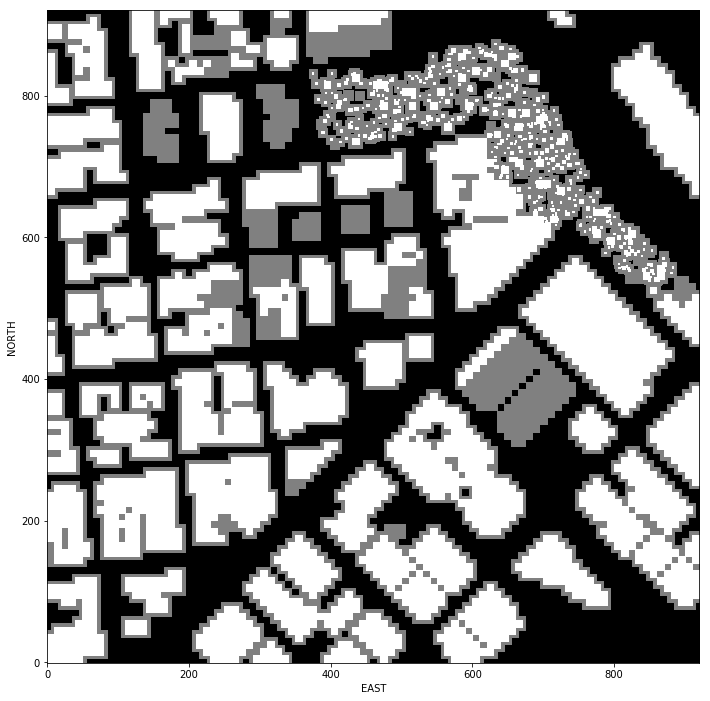

In [8]:
## White is the building area, Gray is the buffer area for safety, 
## and the black is the feasible area for planning
plt.imshow(grid+grid_safe, cmap='gray', origin='lower')          

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

## Step 2 Calculate the Path

In [9]:
start = (317, 445, 0)
goal = (650, 850, -5)

In [11]:
## Implement 2D A* to find a path
path, path_cost = a_star(grid_safe, heuristic, start[:2], goal[:2])

Found a path.


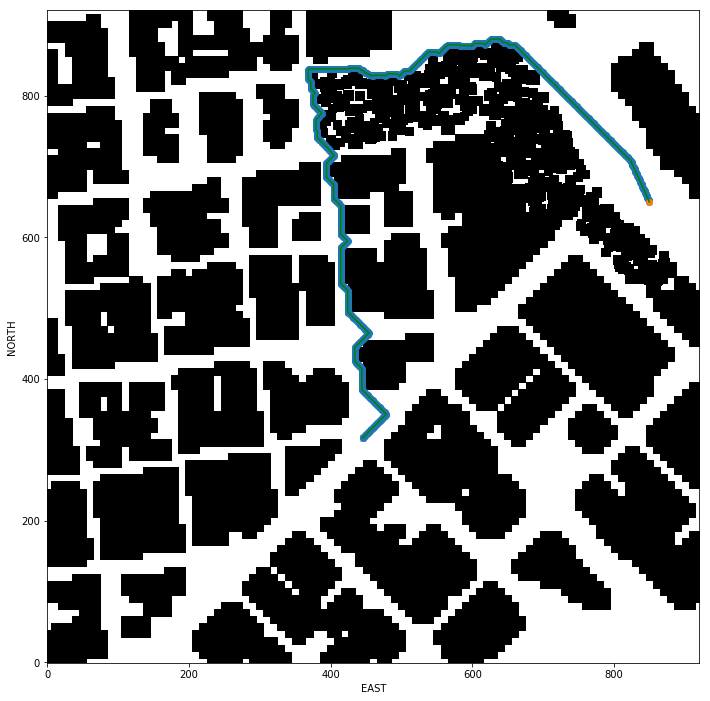

In [12]:
plt.imshow(grid_safe, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start[1], start[0], 'x')
plt.plot(goal[1], goal[0], 'o')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

## Step 3 Pruned path

In [13]:
## Pruned path with collinearity
pruned_path = path_prune(path)
print("Original path has %i waypoints.\i Pruned path has %i waypoints." %(len(path), len(pruned_path)))

Original path has 1035 waypoints.\i Pruned path has 132 waypoints.


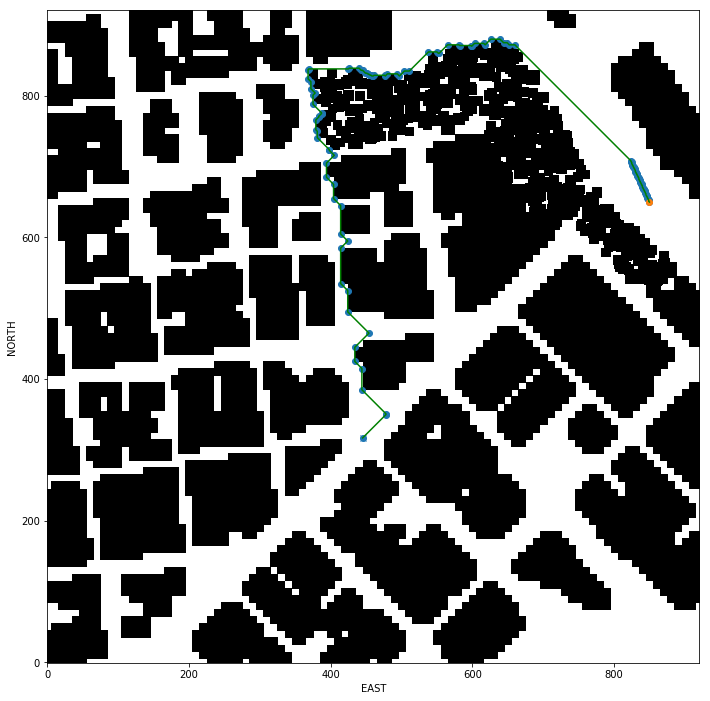

In [14]:
## Visualize the pruned path
plt.imshow(grid_safe, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start[1], start[0], 'x')
plt.plot(goal[1], goal[0], 'o')

if path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Calculate global gps points for start and goal

In [15]:
start = (317, 445, 0)
goal = (430, 420, -5)

In [16]:
lat0, lon0 = 37.792480, -122.397450
global_home = (lon0, lat0)
start_position = (start[0]+north_offset, start[1]+east_offset, start[2])
goal_position = (goal[0]+north_offset, goal[1]+east_offset, goal[2])
global_start = local_to_global(start_position, global_home)
global_goal = local_to_global(goal_position, global_home)

print('Global Start: ', global_start)
print('Global Goal: ', global_goal)

Global Start:  [-122.3974499    37.79248901    0.        ]
Global Goal:  [-122.39772557   37.7935089     5.        ]


## Step 4. Implement in the Simulator

In [17]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [20]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}
        ## add global goal variable
        self.global_goal_position = np.array([-122.39772557, 37.7935089, 5.0], dtype='Float64')

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        filename = 'colliders.csv'
        lat0, lon0 = load_csv(filename)
        
        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(lon0, lat0, 0)
        
        # TODO: retrieve current global position
        # TODO: convert to current local position using global_to_local()
        local_position = global_to_local(self.global_position, self.global_home)
    
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        
        # Define starting point on the grid (this is just grid center)
        # TODO: convert start position to current position rather than map center
        grid_start = (int(np.ceil(local_position[0] - north_offset)), int(np.ceil(local_position[1] - east_offset)))

        # Set goal as some arbitrary position on the grid
        # TODO: adapt to set goal as latitude / longitude position and convert
        local_goal_position = global_to_local(self.global_goal_position, self.global_home)
        grid_goal = (int(np.ceil(local_goal_position[0] - north_offset)), int(np.ceil(local_goal_position[1] - east_offset)))

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # TODO: prune path to minimize number of waypoints
        pruned_path = path_prune(path)
        print("Original path has %i waypoints.\n Pruned path has %i waypoints." %(len(path), len(pruned_path)))
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [21]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)
drone = MotionPlanning(conn)
time.sleep(1)
drone.start()

Logs/TLog.txt


/Users/ElsaW/anaconda3/envs/fcnd/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-122.3974498   37.7924806    0.262    ], local position [ 0.09533816  0.02787608 -0.26153803]
North offset = -316, east offset = -445
Local Start and Goal:  (317, 446) (430, 421)
Found a path.
Original path has 114 waypoints.
 Pruned path has 52 waypoints.
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [1, 1, 5, 0]
waypoint transition
target position [60, 1, 5, 0]
waypoint transition
target position [61, 0, 5, 0]
waypoint transition
target position [62, 0, 5, 0]
waypoint transition
target position [63, -1, 5, 0]
waypoint transition
target position [64, -1, 5, 0]
waypoint transition
target position [65, -2, 5, 0]
waypoint transition
target position [66, -2, 5, 0]
waypoint transition
target position [67, -3, 5, 0]
waypoint transition
target position [68, -3, 5, 0]
waypoint transition
target position [69, -4, 5,